![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.ensemble import BaggingRegressor,RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split



In [ ]:

# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data = data.drop(['Model'], axis=1)

# Visualización dataset
data.head()

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
7,21995,2014,6480,0,0,0,1,0,0,0
11,13995,2014,39972,0,0,0,0,1,0,0
167,17941,2016,18989,0,0,0,0,0,1,0
225,12493,2014,51330,0,0,0,1,0,0,0
270,7994,2007,116065,0,1,0,0,0,0,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10495 entries, 7 to 399976
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   Price        10495 non-null  int64
 1   Year         10495 non-null  int64
 2   Mileage      10495 non-null  int64
 3   M_Camry      10495 non-null  uint8
 4   M_Camry4dr   10495 non-null  uint8
 5   M_CamryBase  10495 non-null  uint8
 6   M_CamryL     10495 non-null  uint8
 7   M_CamryLE    10495 non-null  uint8
 8   M_CamrySE    10495 non-null  uint8
 9   M_CamryXLE   10495 non-null  uint8
dtypes: int64(3), uint8(7)
memory usage: 657.8 KB


In [ ]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['Price']
X = data.drop(['Price'], axis=1)

In [ ]:
# Separación de datos en set de entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el RMSE y MAE del modelo en el set de test.

In [ ]:
# Celda 1
def decision_tree_regression_manual(X, y, max_depth=10):
  def mse_split(X_col, y, split):    
      filter_l = X_col < split
      y_l = y.loc[filter_l]
      y_r = y.loc[~filter_l]
        
      errors_l = y_l-np.mean(y_l)
      errors_r = y_r-np.mean(y_r)
      
      mse = np.average(np.square(np.concatenate([errors_l,errors_r])))
      
      return mse

  # Definición de la función best_split para calcular cuál es la mejor variable y punto de corte para hacer la bifurcación del árbol
  def best_split(X, y, num_pct=10):    
      features = range(X.shape[1])
      
      # Calcular el mse del nodo actual y dejar dicho mse como punto de comparación, puede que sea mejor no particionar.
      mse_node = np.average(np.square(y-y.mean()))
      best_split = [None, None, mse_node]  # j, split, mse
      
      # Para todas las varibles 
      for j in features:
          
          splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
          splits = np.unique(splits)[1:]
          
          # Para cada partición
          for split in splits:
              mse = mse_split(X.iloc[:, j], y, split)
              if mse < best_split[2]:
                  best_split = [j, split, mse]

      return best_split

  # Definición de la función tree_grow para hacer un crecimiento recursivo del árbol
  def tree_grow(X, y, level=0, min_mse=0.001, max_depth=None, num_pct=10):
      
      # Si solo es una observación
      if X.shape[0] == 1:
          tree = dict(y_pred=y.iloc[:1].values[0], level=level, split=-1, n_samples=1, mse=0)
          return tree
      
      # Calcular la mejor división
      j, split, mse = best_split(X, y, num_pct)
      
      # Guardar el árbol y estimar la predicción
      y_pred = y.mean()
      
      tree = dict(y_pred=y_pred, level=level, split=-1, n_samples=X.shape[0], mse=mse)
      
      # Revisar el criterio de parada 
      if mse < min_mse:
          return tree
      if max_depth is not None:
          if level >= max_depth:
              return tree   
      if split is None: # Puede que no se obtenga una nueva partición, ya que al particionar no mejora el mse, o este no se puede calcular porque no hay datos para particionar.
          return tree
      
      # Continuar creando la partición
      filter_l = X.iloc[:, j] < split
      X_l, y_l = X.loc[filter_l], y.loc[filter_l]
      X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
      tree['split'] = [j, split]

      # Siguiente iteración para cada partición
      tree['sl'] = tree_grow(X_l, y_l, level + 1, min_mse=min_mse, max_depth=max_depth, num_pct=num_pct)
      tree['sr'] = tree_grow(X_r, y_r, level + 1, min_mse=min_mse, max_depth=max_depth, num_pct=num_pct)

      return tree
        
  # Llamar a la función recursiva para construir el árbol
  tree = tree_grow(X_train, y_train, max_depth)

  return tree

# Definición de la función tree_predict para hacer predicciones según las variables 'X' y el árbol 'tree'
def tree_predict(X, tree):
    
    predicted = np.ones(X.shape[0])

    # Revisar si es el nodo final
    if tree['split'] == -1:
        predicted = predicted * tree['y_pred']
            
    else:        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # Si el nodo izquierdo está vacio solo continua con el derecho 
            predicted[~filter_l] = tree_predict(X_r, tree['sr'])
        elif X_r.shape[0] == 0:  #  Si el nodo derecho está vacio solo continua con el izquierdo
            predicted[filter_l] = tree_predict(X_l, tree['sl'])
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'])
            predicted[~filter_l] = tree_predict(X_r, tree['sr'])

    return predicted


In [ ]:
#Llamo la funcion que crea el modelo manual
model_manual = decision_tree_regression_manual(X_train,y_train)

#Prediccion para los datos de prueba
y_pred = tree_predict(X_test, model_manual)

In [ ]:
# Calcular métricas en el conjunto de prueba
rmse1 = mean_squared_error(y_test, y_pred, squared=False)
mae1 = mean_absolute_error(y_test, y_pred)

print("Resultado en datos de test:")
print('RMSE:', rmse1, '\nMAE: ', mae1)

Resultado en datos de test:
RMSE: 2070.6983862253587 
MAE:  1554.2617157428792


### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de regresión y comenten sobre el desempeño del modelo.

In [ ]:
#Genero semilla
np.random.seed(42)

#funcion muestras boostrap
def bootstrap(X, y):
    n_samples = X.shape[0]
    indices = np.random.choice(a=n_samples, size=n_samples, replace=True)
    X_bootstrap = X.iloc[indices]
    y_bootstrap = y.iloc[indices]
    return X_bootstrap, y_bootstrap

#funcion bagging
def bagging_regression(X, y, n_estimators):
    models = []
    for i in range(n_estimators):
        X_bootstrap, y_bootstrap = bootstrap(X, y)
        model = DecisionTreeRegressor()
        model.fit(X_bootstrap, y_bootstrap)
        models.append(model)
    return models

#definimps 10 n_estimators
n_estimators = 10
#corro modelo
models = bagging_regression(X_train,y_train, n_estimators)
#hago predicciones
y_pred = np.zeros(X_test.shape[0])
for model in models:
    y_pred += model.predict(X_test)
y_pred /= n_estimators

#calculo rmse y mae
rmse2 = mean_squared_error(y_test, y_pred, squared=False)
mae2 = mean_absolute_error(y_test, y_pred)

print("Resultado en datos de test:")
print('RMSE:', rmse2, '\nMAE: ', mae2)

Resultado en datos de test:
RMSE: 1817.059237864633 
MAE:  1351.3839540280735


### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de regresión y el parámetro `max_features` igual a `log(n_features)` y comenten sobre el desempeño del modelo.

In [ ]:

# inicio decision tree regressor con max_depth=5
tree = DecisionTreeRegressor(max_depth=5, random_state=42)

# Calculo number of features
n_features = X_train.shape[1]

# Calculo del parametro max_features 
max_features = int(np.log2(n_features))

# Instancio bagging regressor con 10 decision trees
bagging = BaggingRegressor(base_estimator=tree, n_estimators=10, max_features=max_features, random_state=42)

# ajusto modelo
bagging.fit(X_train, y_train)

# hago predicciones en test
y_pred = bagging.predict(X_test)

# Calcular métricas en el conjunto de prueba
rmse3 = mean_squared_error(y_test, y_pred, squared=False)
mae3 = mean_absolute_error(y_test, y_pred)

print("Resultado en datos de test:")
print('RMSE:', rmse3, '\nMAE: ', mae3)

Resultado en datos de test:
RMSE: 2275.4119844292454 
MAE:  1745.6883559660855


### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para regresión y comenten sobre el desempeño del modelo.

In [ ]:
# Celda 4

# Crear una instancia del modelo de Random Forest
rf = RandomForestRegressor(random_state=42)

# Entrenar el modelo con los datos de entrenamiento
rf.fit(X_train, y_train)

# Predecir los valores del conjunto de prueba
y_pred = rf.predict(X_test)

# Calcular métricas en el conjunto de prueba
rmse4 = mean_squared_error(y_test, y_pred, squared=False)
mae4 = mean_absolute_error(y_test, y_pred)

print("Resultado en datos de test:")
print('RMSE:', rmse4, '\nMAE: ', mae4)

Resultado en datos de test:
RMSE: 1765.4118259983413 
MAE:  1314.4207078056425


### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

###  **OPCION 1** 
Se analiza el comportamiento del RMSE y MAE por la iteracion de cada parametro

#### Calibración de max_depth



In [ ]:
# Creación de lista de valores para iterar sobre diferentes valores de max_depth
max_depth_range = range(1, 30, 1)

# Definición de lista para almacenar el rmse para cada valor de max_depth
rmse_scores = []
mae_scores = []
# Uso de datos de test para cada valor de n_estimators
for max_depth in max_depth_range:
    reg = RandomForestRegressor(max_depth=max_depth, random_state=42, n_jobs=-1)
    reg.fit(X_train, y_train)
    y_test_pred = reg.predict(X_test)
    rmse_scores.append(mean_squared_error(y_test, y_test_pred, squared=False))
    mae_scores.append(mean_absolute_error(y_test, y_test_pred))


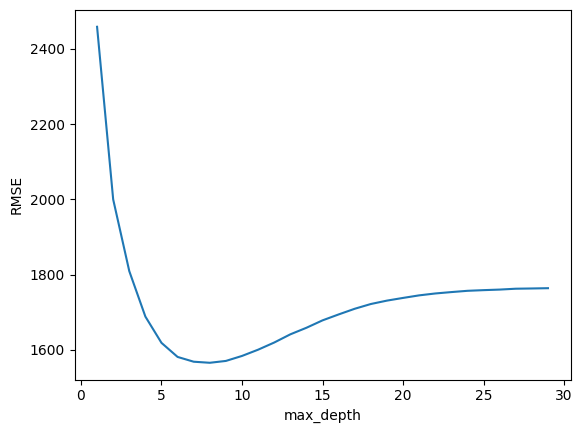

In [ ]:
# Gráfica del desempeño del modelo vs la cantidad de max_depth
plt.plot(max_depth_range, rmse_scores)
plt.xlabel('max_depth')
plt.ylabel('RMSE')
plt.show()


Text(0, 0.5, 'Mae')

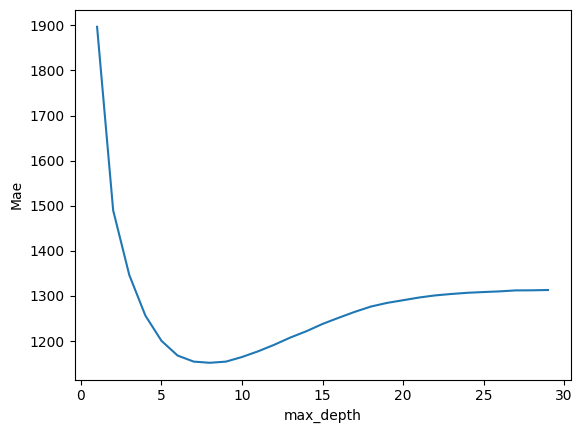

In [ ]:
plt.plot(max_depth_range, mae_scores)
plt.xlabel('max_depth')
plt.ylabel('Mae')

Observamos que  el RMSE llega a su punto mínimo en  el max_depth 8 y desde allì empieza a incrementarse de nuevo. Para comportamiento del MAE pasa lo mismo. Los resultados del menor RMSE y menor MAE se presentan a continuaciòn:

In [ ]:
best_max_depth = max_depth_range[np.argmin(rmse_scores)]
#best_max_depth_2 = max_depth_range[np.argmin(mae_scores)]
print("Menor RMSE: ",min(rmse_scores),"\nMenor mae: ",min(mae_scores),"\nMejor max_depth: ",best_max_depth)

Menor RMSE:  1565.4520388369253 
Menor mae:  1151.7523046441465 
Mejor max_depth:  8


#### Calibración de max_features

In [ ]:
# Creación de lista de valores para iterar sobre diferentes valores de max_features
max_features_range = range(1, X_train.shape[1]+1, 1)

# Definición de lista para almacenar el rmse para cada valor de max_features
rmse_scores = []
mae_scores = []

# Uso de datos de test para cada valor de n_estimators
for max_features in max_features_range:
    reg = RandomForestRegressor(max_depth=best_max_depth, max_features=max_features, random_state=42, n_jobs=-1)
    reg.fit(X_train, y_train)
    y_test_pred = reg.predict(X_test)
    rmse_scores.append(mean_squared_error(y_test, y_test_pred, squared=False))
    mae_scores.append(mean_absolute_error(y_test, y_test_pred))


Text(0, 0.5, 'RMSE')

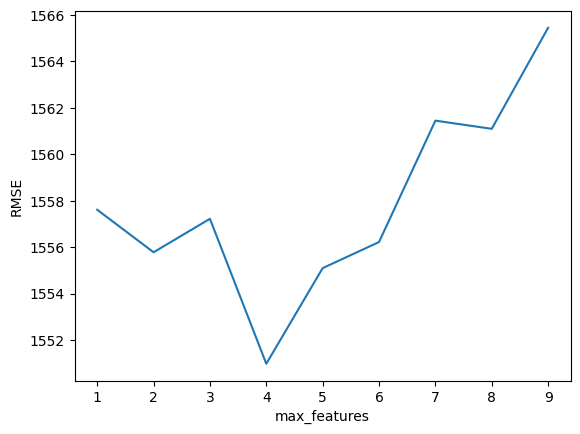

In [ ]:
# Gráfica del desempeño del modelo vs la cantidad de max_features
plt.plot(max_features_range, rmse_scores)
plt.xlabel('max_features')
plt.ylabel('RMSE')

Text(0, 0.5, 'MAE')

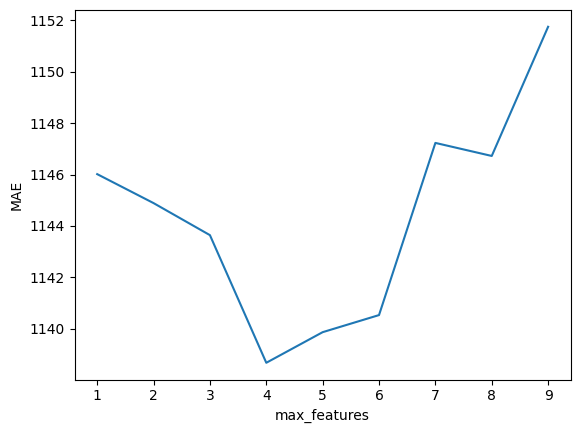

In [ ]:
# Gráfica del desempeño del modelo vs la cantidad de max_features
plt.plot(max_features_range, mae_scores)
plt.xlabel('max_features')
plt.ylabel('MAE')

Observamos que el RMSE llega a su punto mínimo en  el max_features 4 y desde allì empieza a incrementarse de nuevo. Para comportamiento del MAE pasa lo mismo. Los resultados del menor RMSE y menor MAE se presentan a continuaciòn:

In [ ]:
best_max_features = max_features_range[np.argmin(rmse_scores)]
print("Menor RMSE: ",min(rmse_scores),"\nMenor MAE: ",min(mae_scores),"\nMejor max_features: ",best_max_features)

Menor RMSE:  1550.974035428206 
Menor MAE:  1138.675307326621 
Mejor max_features:  4



#### Calibración de n_estimators

In [ ]:
# Creación de lista de valores para iterar sobre diferentes valores de n_estimators
n_estimators_range = range(10, 410, 10)

# Definición de lista para almacenar el rmse para cada valor de n_estimators
rmse_scores = []
mae_scores = []
# Uso de datos de test para cada valor de n_estimators
for n_estimators in n_estimators_range:
    reg = RandomForestRegressor(max_depth=best_max_depth, max_features=best_max_features, n_estimators=n_estimators, random_state=42, n_jobs=-1)
    reg.fit(X_train, y_train)
    y_test_pred = reg.predict(X_test)
    rmse_scores.append(mean_squared_error(y_test, y_test_pred, squared=False))
    mae_scores.append(mean_absolute_error(y_test, y_test_pred))


Text(0, 0.5, 'RMSE')

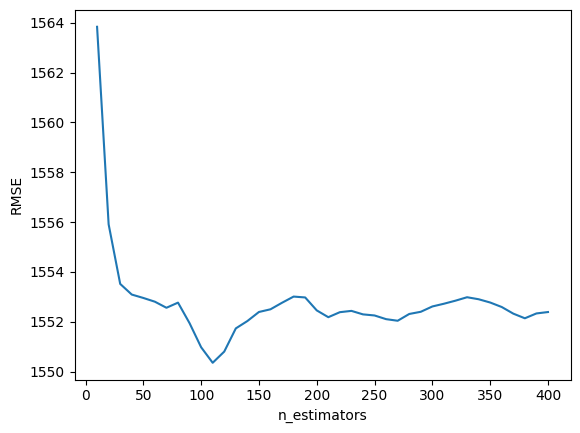

In [ ]:
# Gráfica del desempeño del modelo vs la cantidad de n_estimators
plt.plot(n_estimators_range, rmse_scores)
plt.xlabel('n_estimators')
plt.ylabel('RMSE')

Text(0, 0.5, 'MAE')

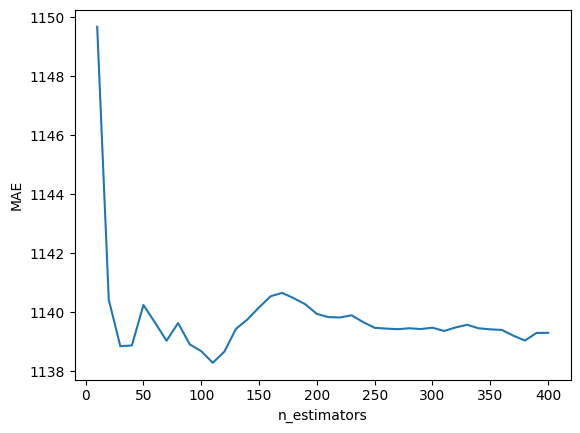

In [ ]:
# Gráfica del desempeño del modelo vs la cantidad de n_estimators
plt.plot(n_estimators_range, mae_scores)
plt.xlabel('n_estimators')
plt.ylabel('MAE')

Observamos que el RMSE llega a su punto mínimo en  el n_estimator 110 y desde allì empieza a incrementarse de nuevo. Para comportamiento del MAE pasa lo mismo. Los resultados del menor RMSE y menor MAE se presentan a continuaciòn:

In [ ]:
best_n_estimators = n_estimators_range[np.argmin(rmse_scores)]
print("Menor RMSE: ",min(rmse_scores),"\nMenor MAE: ",min(mae_scores),"\nMejor n_estimators: ",best_n_estimators)

Menor RMSE:  1550.3504305967538 
Menor MAE:  1138.2825942236877 
Mejor n_estimators:  110


#### Entrenamiento con mejores parámetros

Teniendo en cuenta los mejores parámetros que minimizan el RMSE se ajusta el modelo y se obtienen los siguientes resultados en los datos de test

In [ ]:
reg = RandomForestRegressor(max_depth=best_max_depth, max_features=best_max_features, n_estimators=best_n_estimators, random_state=42, n_jobs=-1)
reg.fit(X_train, y_train)
y_test_pred = reg.predict(X_test)

In [ ]:
rmse5_1 = mean_squared_error(y_test, y_test_pred, squared=False)
mae5_1 = mean_absolute_error(y_test, y_test_pred)

print('RMSE:',rmse5_1, '\nMAE: ',mae5_1)

RMSE: 1550.350430596754 
MAE:  1138.2825942236877


### **OPCION 2**

Se realiza grid search para encontrar los mejores parámetros de una manera más resumida que la opción 1

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Definir los valores de los parámetros a explorar
param_grid = {
    'max_depth': [2, 4, 6, 8],
    'n_estimators': [110, 200, 300],
    'max_features': [4, 'auto', 'sqrt', 'log2']
}

# Crear el modelo de Random Forest Regressor
rf = RandomForestRegressor(random_state=42)

# Realizar la búsqueda en cuadrícula
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Ajustar el modelo a los datos de entrenamiento
grid_search.fit(X_train, y_train)

# Imprimir los mejores parámetros y la mejor puntuación
print('Mejores parámetros:', grid_search.best_params_)
print('Mejor puntuación:', np.sqrt(-grid_search.best_score_))

Mejores parámetros: {'max_depth': 8, 'max_features': 4, 'n_estimators': 300}
Mejor puntuación: 1517.196777559644


Los resultados en los datos de test son:

In [ ]:
# Calcular métricas en el conjunto de prueba
y_pred = grid_search.predict(X_test)

rmse5_2 = mean_squared_error(y_test, y_pred, squared=False)
mae5_2 = mean_absolute_error(y_test, y_pred)

print("Resultado en datos de test:")
print('RMSE:', rmse5_2, '\nMAE: ', mae5_2)


Resultado en datos de test:
RMSE: 1552.6115244841064 
MAE:  1139.4737831734315


### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de regresión con la librería sklearn y comenten sobre el desempeño del modelo.

In [ ]:
# Celda 6
import xgboost as xgb

# iniciar XGBoost regressor
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=123)

# Fit  model 
xgb_model.fit(X_train, y_train)

# Predicciones en test
y_pred = xgb_model.predict(X_test)

# Calcular métricas en el conjunto de prueba
rmse6 = mean_squared_error(y_test, y_pred, squared=False)
mae6 = mean_absolute_error(y_test, y_pred)

print("Resultado en datos de test:")
print('RMSE:', rmse6, '\nMAE: ', mae6)


Resultado en datos de test:
RMSE: 1621.4197004256812 
MAE:  1186.634392366123


### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para clasificación, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

### **OPCION 1** 

Se itera cada valor de los 3 parámetros y se analiza gráficamente el que obtiene menor RMSE

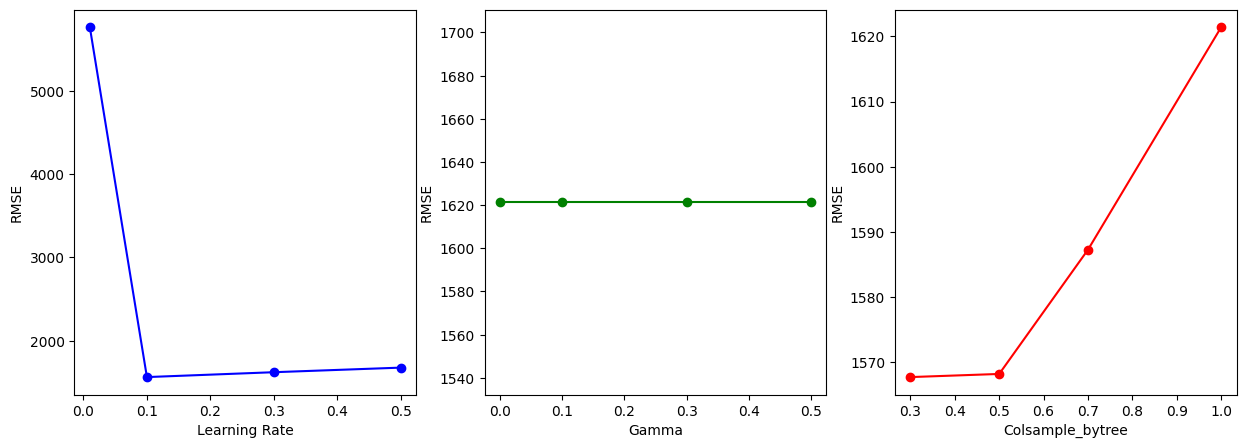

In [ ]:
# Celda 7
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Se definen los parametros cada uno con un rango a iterar
learning_rates = [0.01, 0.1, 0.3, 0.5]
gammas = [0, 0.1, 0.3, 0.5]
colsample_bytrees = [0.3, 0.5, 0.7, 1]

# se establecen las listas vacias para cada parametro
rmse_learning_rate = []
rmse_gamma = []
rmse_colsample_bytree = []

# se hace un loop en cada parametro y se va evaluando en el modelo XGBoost regressor
for lr in learning_rates:
    xgb_model = xgb.XGBRegressor(learning_rate=lr, random_state=123)
    xgb_model.fit(X_train, y_train)
    y_pred = xgb_model.predict(X_test)
    rmse_learning_rate.append(np.sqrt(mean_squared_error(y_test, y_pred)))

for gamma in gammas:
    xgb_model = xgb.XGBRegressor(gamma=gamma, random_state=123)
    xgb_model.fit(X_train, y_train)
    y_pred = xgb_model.predict(X_test)
    rmse_gamma.append(np.sqrt(mean_squared_error(y_test, y_pred)))

for colsample_bytree in colsample_bytrees:
    xgb_model = xgb.XGBRegressor(colsample_bytree=colsample_bytree, random_state=123)
    xgb_model.fit(X_train, y_train)
    y_pred = xgb_model.predict(X_test)
    rmse_colsample_bytree.append(np.sqrt(mean_squared_error(y_test, y_pred)))

# se grafican los resultados
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].plot(learning_rates, rmse_learning_rate, 'bo-')
axes[0].set_xlabel('Learning Rate')
axes[0].set_ylabel('RMSE')
axes[1].plot(gammas, rmse_gamma, 'go-')
axes[1].set_xlabel('Gamma')
axes[1].set_ylabel('RMSE')
axes[2].plot(colsample_bytrees, rmse_colsample_bytree, 'ro-')
axes[2].set_xlabel('Colsample_bytree')
axes[2].set_ylabel('RMSE')
plt.show()


El parámetro de Learning rate con mínimo RMSE esta en 0.1. El parámetro de Gamma con mínimo RMSE se puede escoger entre 0.0 a 0.5 ya que es constante el RMSE.El parámetro de Colsample_bytree con mínimo RMSE esta en 0.3.  

In [ ]:
#los puntos minimos ubicados en las graficas se asignan al modelo
import xgboost as xgb

xgb_model = xgb.XGBRegressor(learning_rate=0.1,gamma=0.1,colsample_bytree=0.3,objective='reg:squarederror', random_state=123)
xgb_model.fit(X_train, y_train)

# predicciones en test
y_pred = xgb_model.predict(X_test)

# Calcular métricas en el conjunto de prueba
rmse7_1 = mean_squared_error(y_test, y_pred, squared=False)
mae7_1 = mean_absolute_error(y_test, y_pred)

print("Resultado en datos de test:")
print('RMSE:', rmse7_1, '\nMAE: ', mae7_1)

Resultado en datos de test:
RMSE: 1572.2297404339524 
MAE:  1159.6065047971097


### **OPCION 2**  
Se utiliza grid search como una manera óptima de realizar el proceso de la opcion 1

In [ ]:
#establezco los valores que tendrá cada parámetro
parametros = {
    'learning_rate': [0.1, 0.01, 0.001],
    'gamma': [0, 1, 2],
    'colsample_bytree': [0.4, 0.6, 0.8]
}

#ajusto el modelo
xgb_model = xgb.XGBRegressor()
#determino el grid con cv 10 y scoring de NMSE
calibracion = GridSearchCV(xgb_model, parametros, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)

calibracion.fit(X_train, y_train)
#genero predicciones
y_pred = calibracion.predict(X_test)

# Calcular métricas en el conjunto de prueba
rmse7_2 = mean_squared_error(y_test, y_pred, squared=False)
mae7_2 = mean_absolute_error(y_test, y_pred)

print("Resultado en datos de test:")
print('RMSE:', rmse7_2, '\nMAE: ', mae7_2)

Resultado en datos de test:
RMSE: 1548.2531414499952 
MAE:  1137.2537362536987


### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

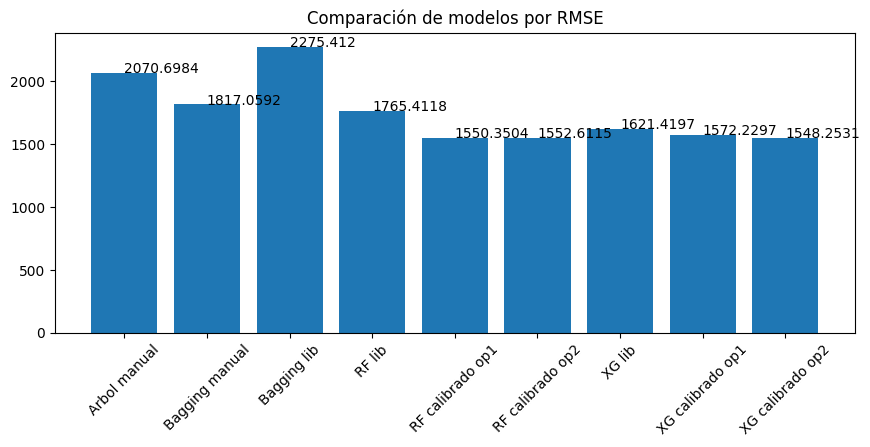

In [ ]:
fig = plt.figure(figsize=[8,3])
ax = fig.add_axes([0,0,1,1])
ax.set_title("Comparación de modelos por RMSE")
#faltan los de filtrado
ejeX = ['Arbol manual','Bagging manual','Bagging lib','RF lib','RF calibrado op1','RF calibrado op2','XG lib','XG calibrado op1','XG calibrado op2']
ejeY = [rmse1,rmse2,rmse3,rmse4,rmse5_1,rmse5_2,rmse6,rmse7_1,rmse7_2]
ejeY = [round(v,4) for v in ejeY]
ax.bar(ejeX,ejeY)
def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i,y[i],y[i])
addlabels(ejeX,ejeY,plt)
plt.xticks(rotation = 45)
plt.show()

**Análisis RMSE:** El modelo que mejor RMSE presenta es el **XG Calibrado opción 2 (grid search)**, seguido de los modelos  RF calibrado opción 2 (grid search) y  RF calibrado opción 1 (max_features, max_depth y n_estimators), con respecto a los modelos Random Forest y XGBoost con paramétros predeterminados. 

**ventajas**: los algoritmos con paramétros ajustados presentan un buen desempeño menor RMSE con respecto a los modelos con una configuración predeterminada.

desventajas: se requiere calibración de paramétros para mejorar el desempeño de los modelos, con el fin de evitar sobreajuste de los mismos.

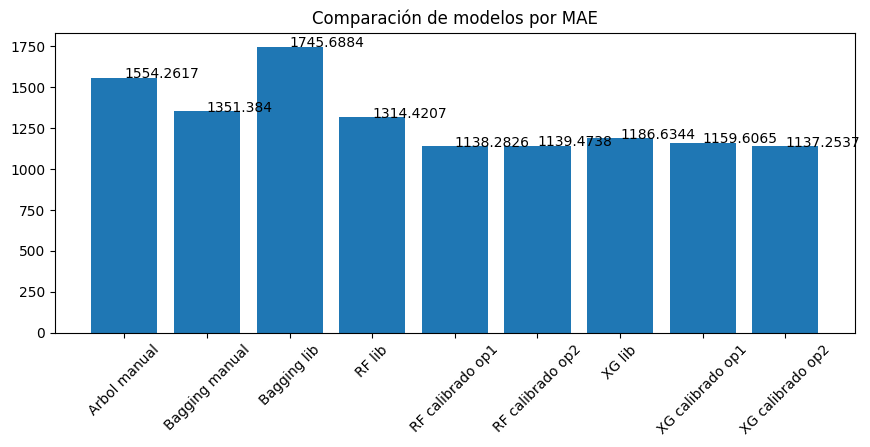

In [ ]:
fig = plt.figure(figsize=[8,3])
ax = fig.add_axes([0,0,1,1])
ax.set_title("Comparación de modelos por MAE")
#faltan los de filtrado
ejeX = ['Arbol manual','Bagging manual','Bagging lib','RF lib','RF calibrado op1','RF calibrado op2','XG lib','XG calibrado op1','XG calibrado op2']
ejeY = [mae1,mae2,mae3,mae4,mae5_1,mae5_2,mae6,mae7_1,mae7_2]
ejeY = [round(v,4) for v in ejeY]
ax.bar(ejeX,ejeY)
def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i,y[i],y[i])
addlabels(ejeX,ejeY,plt)
plt.xticks(rotation = 45)
plt.show()

**Análisis de MAE (promedio absoluto del error):** los modelos con menor MAE son **XG Calibrado opción 2 (grid search)**, seguido del modelo  **RF calibrado opcion 2 (grid search)** presentan un resultado similar y buen desempeño. 

**ventajas:** al contar con mas de un modelo, se evidencia que el error promedio se encuentra entre 1137.25 de precio del vehiculo **XG Calibrado opción 2 (grid search)** y **RF calibrado opcion 2 (grid search)** 1139.47. Por lo que se sugiere al negocio optar por el modelo con menor rango de error en la predicción del precio (**XG Calibrado opción 2 (grid search)**). 

Los resultados de las metricas RMSE y MAE, coincide que los modelos **XG Calibrado opción 2 (grid search)**, y   **RF calibrado opcion 2 (grid search)** cuentan con un buen desempeño en optener el menor error en ambas métricas.

**Desventajas:** se requiere calibración de paramétros para mejorar el desempeño de los modelos, con el fin de evitar sobreajuste de los mismos.